<a href="https://colab.research.google.com/github/kato1329/CATech/blob/main/CNNfeaturemap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5),(0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True,num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True,num_workers=2)

folder_path = './drive/MyDrive/catimage/'

In [46]:
image_name = 'cat1.jpeg'
image_path = folder_path+image_name
image = cv2.imread(image_path)
image = cv2.resize(image,dsize=(28,28))
image = torch.from_numpy(image.transpose(2,0,1)).view(1,3,28,28).to(torch.float32)

In [63]:
class sampleCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,1,kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(1,1,kernel_size=3,padding=1)
    self.conv3 = nn.Conv2d(1,1,kernel_size=3,padding=1)
    self.conv4 = nn.Conv2d(1,1,kernel_size=3,padding=1)
    self.linear1 = nn.Linear(28*28,512)
    self.linear2 = nn.Linear(512,10)
    self.flatten = nn.Flatten()
    self.relu = nn.ReLU()
    self.batchnorm = nn.BatchNorm2d(1)
    self.Softmax = nn.Softmax(dim=1)
  def forward(self,input):
    x = self.relu(self.conv1(input))
    feature_map1 = x[0][0]
    x = self.relu(self.conv2(self.batchnorm(x)))
    feature_map2 = x[0][0]
    x = self.relu(self.conv3(self.batchnorm(x)))
    feature_map3 = x[0][0]
    x = self.relu(self.conv4(self.batchnorm(x)))
    feature_map4 = x[0][0]
    x = self.flatten(x)
    x = self.relu(self.linear1(x))
    x = self.relu(self.linear2(x))
    feature_maps = [feature_map1,feature_map2,feature_map3,feature_map4]
    return x,feature_maps

In [68]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")
model = sampleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

Using cuda device


In [70]:
epoch = 100
from tqdm import tqdm

In [67]:
tmp = iter(trainloader)
with torch.no_grad():
  for batch in tmp:
    inputs,labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    pred,_ = model(inputs)
    print("predのshapeは{}".format(pred.shape))

    loss = criterion(pred,labels)
    pred_label = torch.max(pred,1)[1]
    print("pred_labelのshapeは{}".format(pred_label.shape))
    print("labelsのshapeは{}".format(labels.shape))
    print("pred_labelの1-10番目は{}".format(pred_label[:10]))
    print("labelsの1-10番目は{}".format(labels[:10]))
    test_accuracy = torch.sum(pred_label==labels).item()/len(labels)
    print("accuracyは{}".format(test_accuracy))
    break

predのshapeはtorch.Size([128, 10])
pred_labelのshapeはtorch.Size([128])
labelsのshapeはtorch.Size([128])
pred_labelの1-10番目はtensor([6, 2, 2, 1, 6, 0, 1, 0, 1, 2], device='cuda:0')
labelsの1-10番目はtensor([9, 1, 7, 7, 7, 5, 5, 0, 1, 8], device='cuda:0')
accuracyは0.15625


In [ ]:
for i in range(epoch):
  print('---------------------')
  print("Epoch:{}/{}".format(i+1,epoch))

  train_loss = 0
  train_accuracy = 0
  test_loss = 0
  test_accuracy = 0

  model.train()

  for batch in tqdm(trainloader):
    optimizer.zero_grad()

    inputs,labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    pred,_ = model(inputs)
    loss = criterion(pred,labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    pred_label = torch.max(pred,1)[1]
    train_accuracy += torch.sum(pred_label==labels).item()/len(labels)
  train_loss = train_loss/len(trainloader)
  train_accuracy = train_accuracy/len(trainloader)
  print("train_loss = {}".format(train_loss))
  print("train_acc = {}".format(train_accuracy))
  model.eval()
  with torch.no_grad():
    for batch in tqdm(testloader):
      inputs,labels = batch
      inputs = inputs.to(device)
      labels = labels.to(device)
      pred,_ = model(inputs)
      loss = criterion(pred,labels)
      test_loss += loss.item()
      pred_label = torch.max(pred,1)[1]
      test_accuracy += torch.sum(pred_label==labels).item()/len(labels)
  test_loss = test_loss/len(testloader)
  test_accuracy = test_accuracy/len(testloader)
  print("test_loss = {}".format(test_loss))
  print("test_acc = {}".format(test_accuracy))

In [98]:
tmp = iter(trainloader)
model.eval()
feature_map = []
input_image = torch.Tensor()
with torch.no_grad():
  for batch in tmp:
    inputs,labels = batch
    input_image = inputs[0]
    inputs = inputs.to(device)
    labels = labels.to(device)
    pred,feature_maps = model(inputs)
    print("predのshapeは{}".format(pred.shape))
    loss = criterion(pred,labels)
    pred_label = torch.max(pred,1)[1]
    print("pred_labelのshapeは{}".format(pred_label.shape))
    print("labelsのshapeは{}".format(labels.shape))
    print("pred_labelの1-10番目は{}".format(pred_label[:10]))
    print("labelsの1-10番目は{}".format(labels[:10]))
    test_accuracy = torch.sum(pred_label==labels).item()/len(labels)
    print("accuracyは{}".format(test_accuracy))
    print(len(feature_maps))
    feature_map.append(feature_maps[0].to('cpu'))
    feature_map.append(feature_maps[1].to('cpu'))
    feature_map.append(feature_maps[2].to('cpu'))
    feature_map.append(feature_maps[3].to('cpu'))
    break

predのshapeはtorch.Size([128, 10])
pred_labelのshapeはtorch.Size([128])
labelsのshapeはtorch.Size([128])
pred_labelの1-10番目はtensor([4, 9, 3, 1, 8, 1, 3, 1, 5, 6], device='cuda:0')
labelsの1-10番目はtensor([4, 9, 3, 1, 8, 1, 3, 0, 5, 6], device='cuda:0')
accuracyは0.96875
4


In [99]:
input_image.shape

torch.Size([1, 28, 28])

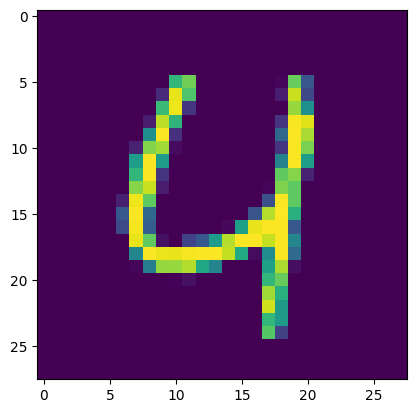

In [100]:
img = input_image.permute(1,2,0) # CHW -> HWC
plt.imshow(img)

In [101]:
feature_map = np.stack(feature_map,axis=0)

In [102]:
print(feature_map.shape)

(4, 28, 28)


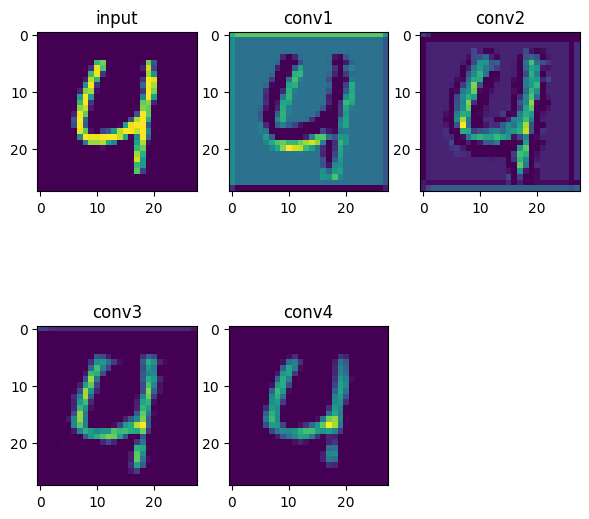

In [107]:
fig = plt.figure(figsize=(7,7))

ax0 = fig.add_subplot(2,3,1)
ax0.imshow(input_image.permute(1,2,0),cmap='viridis')
ax0.set_title('input')

ax1 = fig.add_subplot(2,3,2)
ax1.imshow(feature_map[0],cmap='viridis')
ax1.set_title('conv1')

ax2 = fig.add_subplot(2,3,3)
ax2.imshow(feature_map[1],cmap='viridis')
ax2.set_title('conv2')

ax3 = fig.add_subplot(2,3,4)
ax3.imshow(feature_map[2],cmap='viridis')
ax3.set_title('conv3')

ax4 = fig.add_subplot(2,3,5)
ax4.imshow(feature_map[3],cmap='viridis')
ax4.set_title('conv4')

plt.show()